# Sephora Sentiment Classifer
- EDA
- Naive Bay 
- BERT


## Data Import 

In [22]:
import pandas as pd
import plotly.express as px
from wordcloud import WordCloud
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
latest_review = pd.read_csv('data/latest_review.csv')
latest_review

/var/folders/8z/fr1y76rn6js5w526_mc9y1hh0000gn/T/ipykernel_68898/3069159442.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  latest_review = pd.read_csv('data/latest_review.csv')


,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,...,product_name,brand_name,price_usd,primary_category,secondary_category,tertiary_category,lemma_text,NLTK_text,true_sentiment,length
0,1796832802,3,0.0,0.714286,7,2,5,2022-12-31,I decided to try this as I had never used a li...,"Decent, but cheaper products do the trick",...,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,decided try never used lip mask night find sme...,<Text: decided try never used lip mask night f...,neutral,172
1,10255886039,2,0.0,0.500000,2,1,1,2022-12-31,Might as well be putting on Vaseline because I...,Where’s the smell??,...,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,might well putting vaseline barely smell berry...,<Text: might well putting vaseline barely smel...,negative,160
2,5049431408,5,1.0,1.000000,4,0,4,2022-12-31,Love this lip mask nothing else will do Aquaph...,Must buy!,...,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,love lip mask nothing else aquaphor vaseline a...,<Text: love lip mask nothing else aquaphor vas...,positive,92
3,7052423388,4,1.0,0.333333,3,2,1,2022-12-31,I really enjoy this product! Amazing smell and...,Lovely smell,...,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,really enjoy product amazing smell perfect con...,<Text: really enjoy product amazing smell perf...,positive,148
4,23120633832,5,1.0,0.500000,2,1,1,2022-12-31,The best. I have nothing else to really say ot...,Amazing,...,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,best nothing else really say run buy,<Text: best nothing else really say run buy...>,positive,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192222,9109189891,5,1.0,NaN,0,0,0,2022-04-29,I LOVE this stuff! It works amazingly well at ...,Great product!,...,Hydro Ungrip Makeup Remover + Cleansing Water,MILK MAKEUP,32.0,Skincare,Cleansers,Makeup Removers,love stuff work amazingly well taking waterpro...,<Text: love stuff work amazingly well taking w...,positive,153
192223,8115925555,5,1.0,NaN,0,0,0,2022-04-29,love this micellar water from Milk! it removes...,NaN,...,Hydro Ungrip Makeup Remover + Cleansing Water,MILK MAKEUP,32.0,Skincare,Cleansers,Makeup Removers,love micellar water milk remove everything qui...,<Text: love micellar water milk remove everyth...,positive,133
192224,10723607564,5,1.0,NaN,0,0,0,2022-04-29,I loveeeeee Milk!!! Just discovered this brand...,NaN,...,Hydro Ungrip Makeup Remover + Cleansing Water,MILK MAKEUP,32.0,Skincare,Cleansers,Makeup Removers,loveeeeee milk discovered brand amazing perfec...,<Text: loveeeeee milk discovered brand amazing...,positive,125
192225,5953458355,5,1.0,NaN,0,0,0,2022-04-29,"My new favorite makeup remover. First of all, ...",Works extremely well,...,Hydro Ungrip Makeup Remover + Cleansing Water,MILK MAKEUP,32.0,Skincare,Cleansers,Makeup Removers,new favorite makeup remover first love compone...,<Text: new favorite makeup remover first love ...,positive,255


## Model Training Baseline

In [68]:
from sentiment_nb import remove_plural_preprocessor
from sentiment_nb import train_naive_bayes_classifier 
from sentiment_nb import get_accuracy 
from sentiment_nb import get_confusion_matrix


In [69]:
data = latest_review
text_col = 'review_text'

# Train the Naive Bayes classifier and get accuracy for train and test sets, and confusion matrix
classifier, train_accuracy, test_accuracy, confusion_mat = train_naive_bayes_classifier(data, text_col)

# Print accuracy for train and test sets
print(f'Train Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

# Print confusion matrix
print('Confusion Matrix:')
print(confusion_mat)

# Get accuracy for the entire dataset (can be used for validation or unseen data)
overall_accuracy = get_accuracy(classifier, data, text_col)
print(f'Overall Accuracy: {overall_accuracy:.2f}')


UnboundLocalError: local variable 'words' referenced before assignment

## EDA

In [3]:
latest_review.columns

Index(['author_id', 'rating', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time', 'review_text',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd',
       'primary_category', 'secondary_category', 'tertiary_category',
       'lemma_text', 'NLTK_text', 'true_sentiment', 'length'],
      dtype='object')

#### understanding the target variables/lebal

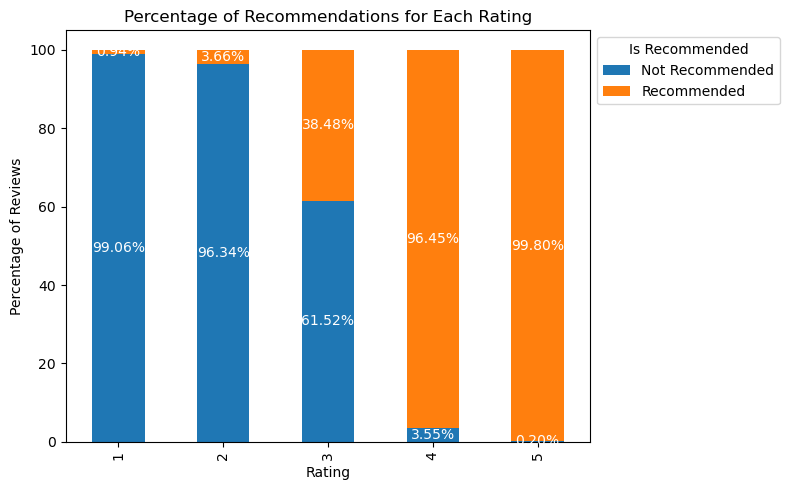

In [41]:
# Pivot the data to get counts of recommendations for each rating
pivot_data = latest_review.groupby(['rating', 'is_recommended']).size().unstack().fillna(0)

# Calculate the percentage for each rating
pivot_data_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Plotting
ax = pivot_data_percentage.plot(kind='bar', stacked=True, figsize=(8, 5))
ax.set_title('Percentage of Recommendations for Each Rating')
ax.set_xlabel('Rating')
ax.set_ylabel('Percentage of Reviews')

# Adjust legend to be outside the plot
ax.legend(title="Is Recommended", labels=["Not Recommended", "Recommended"], loc="upper left", bbox_to_anchor=(1, 1))

# Annotate with the percentage values
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x+width/2, y+height/2, f"{height:.2f}%", ha='center', va='center', color='white')

plt.tight_layout()
plt.show()


logically, user give higher ratings would more likely to recommend certain products. But, why some users recommend a product even if they give it a rating of 1, and conversely, why some don't recommend a product even if they give it a rating of 5?
- Sample top 10 helpful(helpfulness) review where a user gave a rating of 1 but recommended the product.
- Sample top 10 helpful(helpfulness) review where a user gave a rating of 5 but didn't recommend the product.
- Generate word cloud for each type

In [56]:
# Adjust pandas display options
pd.set_option('display.max_colwidth', None)

In [57]:
# give 1 but recommend

# Fetching reviews where users gave a rating of 1 but recommended the product
recommended_with_1 = latest_review[(latest_review['rating'] == 1) & (latest_review['is_recommended'] == 1)]

# Display the top 10 reviews based on helpfulness
top_10_reviews = recommended_with_1.nlargest(10, 'helpfulness')
display(top_10_reviews[['review_text', 'review_title', 'product_name', 'brand_name', 'price_usd']])

,review_text,review_title,product_name,brand_name,price_usd
38428,"Love the original, hate the refill. Purchased the refill to save some money and plastic. I followed the instructions to replace the refill and The pump no longer works and I can’t unscrew the refill to get the product out by hand. I’ve essentially wasted the $42 and my local Sephora doesn’t carry this product so I can’t exchange it. I’m just going to see if I can break the container open to salvage some of my purchase. Don’t buy the refill.",NaN,Barrier+ Triple Lipid-Peptide Face Cream,Skinfix,54.0
39527,"Love the original, hate the refill. Purchased the refill to save some money and plastic. I followed the instructions to replace the refill and The pump no longer works and I can’t unscrew the refill to get the product out by hand. I’ve essentially wasted the $42 and my local Sephora doesn’t carry this product so I can’t exchange it. I’m just going to see if I can break the container open to salvage some of my purchase. Don’t buy the refill.",NaN,Mini Barrier+ Triple Lipid-Peptide Face Cream,Skinfix,20.0
42566,"It feels very cooling when first applied, but that’s it. It doesnt work, it doesn’t depuff, it doesn’t anything. I’ve been using it for months and I haven’t seen any change at all. It does absorb easily and the gel like texture makes it easy to apply in specific areas, but it doesn’t do anything.",Doesn't work,Caffeine 5% + EGCG Depuffing Eye Serum,The Ordinary,8.9
54137,I didn’t use this product because it did not have a safety seal when you opened it. It was just there. I prefer not to put product around my eyes.,I didn't use it,Advanced Night Repair Eye Gel-Cream,Estée Lauder,72.0
58368,"I do not like the knew packaging. A lot more formula comes out, I feel like I use more product now then before before and the bottle keeps opening all together I constantly have to be Putting it back together",I miss the old formula,C-Firma Fresh Vitamin-C Day Serum,Drunk Elephant,78.0
62118,The product is perfect but imagine purchasing the item and have a complete reaction due to the product being expired!! Thank you Sephora for not pulling your expired items off the shelf. Expectation date May 2022 and it’s almost 2023. I returned the product for an exchange but all of them were expired!Speechless!!,Check The Expiration Date,CC+ Cream Oil-Free Matte with SPF 40,IT Cosmetics,44.0
87609,"The old formula was 10 stars. I’ve been loyal to it for probably 7 years, and I’m a product junkie. Nothing beat the old formula.It’s probably not 1 star now, but compared to the old formula which was 10 stars, the new formula is 1 by comparison. The old formula gave a squeaky clean feeling, got rid of blackheads and other skin issues.New formula isn’t just thicker, it doesn’t give the squeaky clean feeling that the old formula had, it doesn’t clear blackheads or dry skin acne.I have dry skin, with acne and the old formula fixed that. The new formula just isn’t the same at all.","New formula isn’t the same, completely different",Purifying Gentle Foaming Cleanser with Salicylic Acid,Clarins,30.0
88070,"Love this cream, BUT this is my second time getting one and the pump doesn’t work!!! So frustrating. Expensive cream that works magic, but the pump will not start. I tossed receipt out because I know I love the cream but what a waste.",NaN,Triple Active Retinol Gentle Overnight Renewal Cream,Dr. Brandt Skincare,75.0
102364,"Unfortunately this was extremely harsh on my sensitive skin. It completely broke my skin out-on & around all areas applied. I was given this to sample by BuzzAgent & I’m thankful for the opportunity to try this product. I can understand more what my skin can & cannot tolerate. Just because it didn’t work for me, doesn’t mean it won’t work for you. Kiehl’s has amazing products. You just have to find the right serum & face products for your skin type.",NaN,Clearly Corrective Dark Spot Correcting Serum,Kiehl's Since 1851,65.0
102683,"Unfortunately this was extremely hars

In [58]:
# give 5 but dont recommend 

# Fetching reviews where users gave a rating of 5 but didn't recommend the product
not_recommended_with_5 = latest_review[(latest_review['rating'] == 5) & (latest_review['is_recommended'] == 0)]

# Display the top 10 reviews based on helpfulness
top_10_reviews_not_recommended = not_recommended_with_5.nlargest(10, 'helpfulness')
display(top_10_reviews_not_recommended[['review_text', 'review_title', 'product_name', 'brand_name', 'price_usd']])


,review_text,review_title,product_name,brand_name,price_usd
1535,"Love this cleanser, use it every day. Very gentle on dry skin. Doesn’t take off my makeup super well so I use it as the second part of a double cleanse if I wear makeup.",NaN,Soy Hydrating Gentle Face Cleanser,fresh,39.0
1556,Soft and nice. Smells almost neutral. Does not dry out my skin.,NaN,Soy Hydrating Gentle Face Cleanser,fresh,39.0
4109,"I have very sensitive, combination skin. This cleanser is the only one I’ve been able to find that has cleared my skin after one use, and keeps my skin under control all around. It’s gentle, but really deeply cleanses without over stripping it. I keep coming back to it time and time again.",GO TO,Superfood Antioxidant Cleanser,Youth To The People,39.0
4960,"I have very sensitive, combination skin. This cleanser is the only one I’ve been able to find that has cleared my skin after one use, and keeps my skin under control all around. It’s gentle, but really deeply cleanses without over stripping it. I keep coming back to it time and time again.",GO TO,Mini Superfood Antioxidant Cleanser,Youth To The People,14.0
7637,Loved it deff worth the money for the full size. I don’t use it often but when my skin just need a gentle scrub this is my go to. It feels so smooth & clean after.,Loved it,Mini Daily Microfoliant Exfoliator,Dermalogica,18.0
10201,Loved it deff worth the money for the full size. I don’t use it often but when my skin just need a gentle scrub this is my go to. It feels so smooth & clean after.,Loved it,Daily Microfoliant Exfoliator,Dermalogica,65.0
14584,Best moisturizer for my combination skin. I’ve been using for a little over a year now and my skin has changed drastically,NaN,The Water Cream Oil-Free Pore Minimizing Moisturizer,Tatcha,70.0
14813,Best moisturizer for my combination skin. I’ve been using for a little over a year now and my skin has changed drastically,NaN,Mini The Water Cream,Tatcha,22.0
14990,It works amazing for sensitive yet acne prone skin,A must have !,Hyaluronic Acid 2% + B5 Hydrating Serum,The Ordinary,15.7
15149,Excelent product! Excelent price and size!Recommended 100%,NaN,Hyaluronic Acid 2% + B5 Hydrating Serum,The Ordinary,15.7


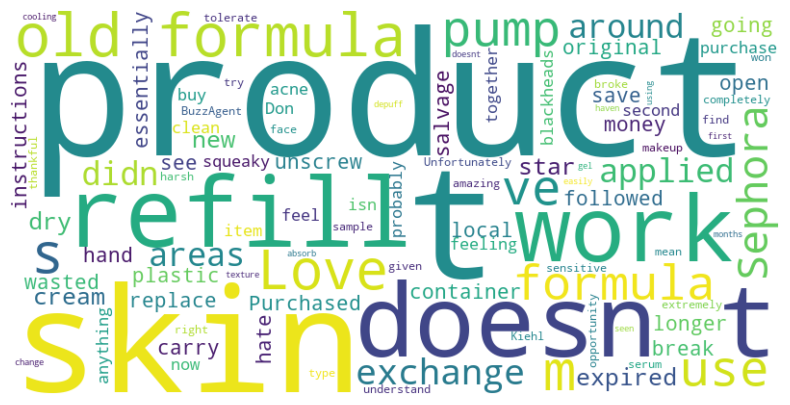

In [49]:
# Combining the text from the sampled reviews
combined_reviews = pd.concat([most_helpful_recommended_with_1, most_helpful_not_recommended_with_5])
combined_text = " ".join(review for review in combined_reviews['review_text'])

# Generating the word cloud
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue', width=800, height=400)
wordcloud.generate(combined_text)

# Displaying the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [48]:
import pandas as pd
from IPython.display import display
import ipywidgets as widgets

# Fetching reviews where users gave a rating of 1 but recommended the product
recommended_with_1 = latest_review[(latest_review['rating'] == 1) & (latest_review['is_recommended'] == 1)]

def display_top_n_reviews(n):
    """
    Display the top N reviews based on helpfulness
    """
    top_n_reviews = recommended_with_1.nlargest(n, 'helpfulness')
    display(top_n_reviews[['author_id', 'rating', 'review_text', 'helpfulness']])

# Create an interactive slider for selecting top N reviews
widgets.interactive(display_top_n_reviews, n=widgets.IntSlider(min=1, max=100, step=1, value=10, description='Top N:'))


interactive(children=(IntSlider(value=10, description='Top N:', min=1), Output()), _dom_classes=('widget-inter…

In [9]:
def plot_wordcloud(data):
    wc = WordCloud(background_color='white', width=500, height=400, max_words=100).generate(' '.join(data))
    fig = px.imshow(wc, template='plotly_white')
    fig.update_layout(coloraxis_showscale=False)
    return fig


In [10]:
def display_reviews(data):
    sorted_data = data.sort_values(by=['helpfulness', 'submission_time'], ascending=[False, False]).head(10)
    fig = go.Figure(data=[go.Table(header=dict(values=['Review Text']),
                 cells=dict(values=[sorted_data['review_text']]))
                     ])
    fig.update_layout(title_text='10 Sample Reviews with Highest Helpfulness or Latest Date')
    return fig